In [1]:
import pandas as pd
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime

In [2]:
import multiprocessing as mp

import gensim
import spacy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from gensim.models import Phrases, LdaModel, LdaMulticore, CoherenceModel
from gensim.corpora import Dictionary
from sklearn.datasets import fetch_20newsgroups

In [20]:
from sentence_transformers import SentenceTransformer
from umap import UMAP
from hdbscan import HDBSCAN
from sklearn.feature_extraction.text import CountVectorizer
from bertopic import BERTopic
from bertopic.vectorizers import ClassTfidfTransformer
import multiprocessing as mp

In [ ]:

df_news_final_project = pd.read_parquet('https://storage.googleapis.com/msca-bdp-data-open/news_final_project/news_final_project.parquet', engine='pyarrow')
df_news_final_project.shape

(200588, 5)

In [2]:
df_news_final_project.head()

,url,date,language,title,text
0,http://spaceref.com/astronomy/observation-simu...,2021-07-05,en,"Observation, Simulation, And AI Join Forces To...","\n\nObservation, Simulation, And AI Join Force..."
1,http://www.agoravox.it/Covid-19-un-messaggio-d...,2020-03-13,en,Covid-19: un messaggio dai ricercatori italian...,\n\n\nCovid-19: un messaggio dai ricercatori i...
2,http://www.dataweek.co.za/21690r,2024-04-05,en,Flash for AI - 28 March 2024 - EBV Electrolink...,\nFlash for AI - 28 March 2024 - EBV Electroli...
3,http://www.envirolink.org/2021/03/11/hundreds-...,2021-03-11,en,Hundreds of sewage leaks detected thanks to AI...,\nHundreds of sewage leaks detected thanks to ...
4,http://www.millenniumpost.in/big-stories/ai-ex...,2020-08-07,en,Two dead as AI Express flight skids off Kozhik...,Two dead as AI Express flight skids off Kozhik...


## Data Inspection and Profiling

In [27]:
df = df_news_final_project

In [28]:
print(df['language'].value_counts())
print("-------date---------")
print(df['date'].min(), df['date'].max())
print("---------title lenth-----------")
print(df['title'].apply(len).describe())
print("---------content lenth-----------")
print(df['text'].apply(len).describe())


language
en    200588
Name: count, dtype: int64
-------date---------
2020-01-01 2024-11-07
---------title lenth-----------
count    200588.000000
mean         90.682788
std          46.872496
min           6.000000
25%          67.000000
50%          83.000000
75%         106.000000
max        6350.000000
Name: title, dtype: float64
---------content lenth-----------
count    200588.000000
mean       8816.008266
std        7854.413372
min          18.000000
25%        5182.000000
50%        7394.000000
75%       10856.000000
max      996452.000000
Name: text, dtype: float64


## Preprocess: 
### sanitize the data of web crawl remnants and discard irrelevant articles

In [31]:
# Define the list of keywords to filter by
keywords = ["data science", "machine learning", "artificial intelligence", "ai", "data"]

# Combine keywords into a regex pattern for case-insensitive matching
keyword_pattern = '|'.join(keywords)

# Filter rows where any keyword is found in the title column (case-insensitive)
df = df[df['title'].str.contains(keyword_pattern, case=False, na=False)]

In [32]:
df.shape

(187399, 5)

In [33]:
# a. Remove URLs
df['text'] = df['text'].str.replace(r'http\S+', '', regex=True)

# b. Remove remnants of web crawls (tabs, newlines, non-printable characters)
df['text'] = df['text'].str.replace(r'\n|\t', ' ', regex=True).str.strip()

# c. Remove non-ASCII characters
df['text'] = df['text'].str.encode('ascii', 'ignore').str.decode('ascii')

# d. Remove email addresses
df['text'] = df['text'].str.replace(r'\S+@\S+', '', regex=True)

# e. Normalize text by stripping excess spaces
df['text'] = df['text'].str.replace(r'\s+', ' ', regex=True)

# f. Remove non-English characters and symbols (e.g., "·")
df['text'] = df['text'].str.replace(r'[^a-zA-Z0-9\s.,?!]', '', regex=True)

# g. Remove everything after "Copyright", including "Copyright"
df['text'] = df['text'].str.split('Copyright').str[0]

/tmp/ipykernel_5643/1640002215.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['text'] = df['text'].str.replace(r'http\S+', '', regex=True)
/tmp/ipykernel_5643/1640002215.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['text'] = df['text'].str.replace(r'\n|\t', ' ', regex=True).str.strip()
/tmp/ipykernel_5643/1640002215.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in th

In [24]:
pd.set_option('display.max_colwidth', None) 

In [25]:
print(df[["text"]].iloc[0])

text    Observation, Simulation, And AI Join Forces To Reveal A Clear Universe  SpaceRef Home  NASA Watch SpaceRef Business Astrobiology Web Advertising Add an Event Sign up for our Daily Newsletter International Space Station NASA Hack Space Calendar Missions Space Weather Observation, Simulation, And AI Join Forces To Reveal A Clear Universe Press Release  Source NATIONAL INSTITUTES OF NATURAL SCIENCES Posted July 4, 2021 1000 PM View Comments Using AI driven data analysis to peel back the noise and find the actual shape of the Universe. CREDIT The Institute of Statistical Mathematics Japanese astronomers have developed a new artificial intelligence AI technique to remove noise in astronomical data due to random variations in galaxy shapes. After extensive training and testing on large mock data created by supercomputer simulations, they then applied this new tool to actual data from Japans Subaru Telescope and found that the mass distribution derived from using this method is consis

In [26]:
df.to_csv("preprocessed_df.csv")

In [29]:
print(df['language'].value_counts())
print("-------date---------")
print(df['date'].min(), df['date'].max())
print("---------title lenth-----------")
print(df['title'].apply(len).describe())
print("---------content lenth-----------")
print(df['text'].apply(len).describe())

language
en    200588
Name: count, dtype: int64
-------date---------
2020-01-01 2024-11-07
---------title lenth-----------
count    200588.000000
mean         90.682788
std          46.872496
min           6.000000
25%          67.000000
50%          83.000000
75%         106.000000
max        6350.000000
Name: title, dtype: float64
---------content lenth-----------
count    200588.000000
mean       8816.008266
std        7854.413372
min          18.000000
25%        5182.000000
50%        7394.000000
75%       10856.000000
max      996452.000000
Name: text, dtype: float64


## Sentiment Analysis

In [39]:
analyzer = SentimentIntensityAnalyzer()

def get_vader_sentiment(text):
    scores = analyzer.polarity_scores(text)
    return scores['compound']

# Use joblib to process in parallel
sentiment_scores = Parallel(n_jobs=16)(delayed(get_vader_sentiment)(text) for text in df['text'])

# Add the results back to the DataFrame
df['sentiment_score'] = sentiment_scores

/tmp/ipykernel_5643/654079360.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['sentiment_score'] = sentiment_scores


In [44]:
df.head().to_csv("viz.csv")

In [41]:
df['sentiment_label'] = df['sentiment_score'].apply(
    lambda x: 'Positive' if x > 0 else 'Negative' 
)

/tmp/ipykernel_5643/3168580158.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['sentiment_label'] = df['sentiment_score'].apply(


In [43]:
df.to_csv("data_with_sentiments.csv")

In [50]:
monthly_sentiment = df.resample('Y', on='date')['sentiment_score'].mean().reset_index()
plt.figure(figsize=(15, 6))
plt.plot(monthly_sentiment['date'], monthly_sentiment['sentiment_score'], 
            marker='o', linestyle='-', markersize=8)

plt.title('Yearly Average Sentiment Score', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Average Sentiment Score', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

plt.ylim(bottom=0.8)

plt.tight_layout()
plt.xticks(rotation=45)
plt.axhline(y=0, color='red', linestyle='--', linewidth=1)

plt.savefig('yearly_sentiment.png', dpi=300, bbox_inches='tight')
plt.close()


/tmp/ipykernel_5643/720223723.py:1: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  monthly_sentiment = df.resample('Y', on='date')['sentiment_score'].mean().reset_index()


In [49]:
df = pd.read_csv("data_with_sentiments.csv")

In [50]:
df = df[df['text'].notna()]

In [51]:
df[['sentiment_label']].value_counts()

sentiment_label
Positive           176161
Negative            11225
Name: count, dtype: int64

In [55]:
df['date'] = pd.to_datetime(df['date'])

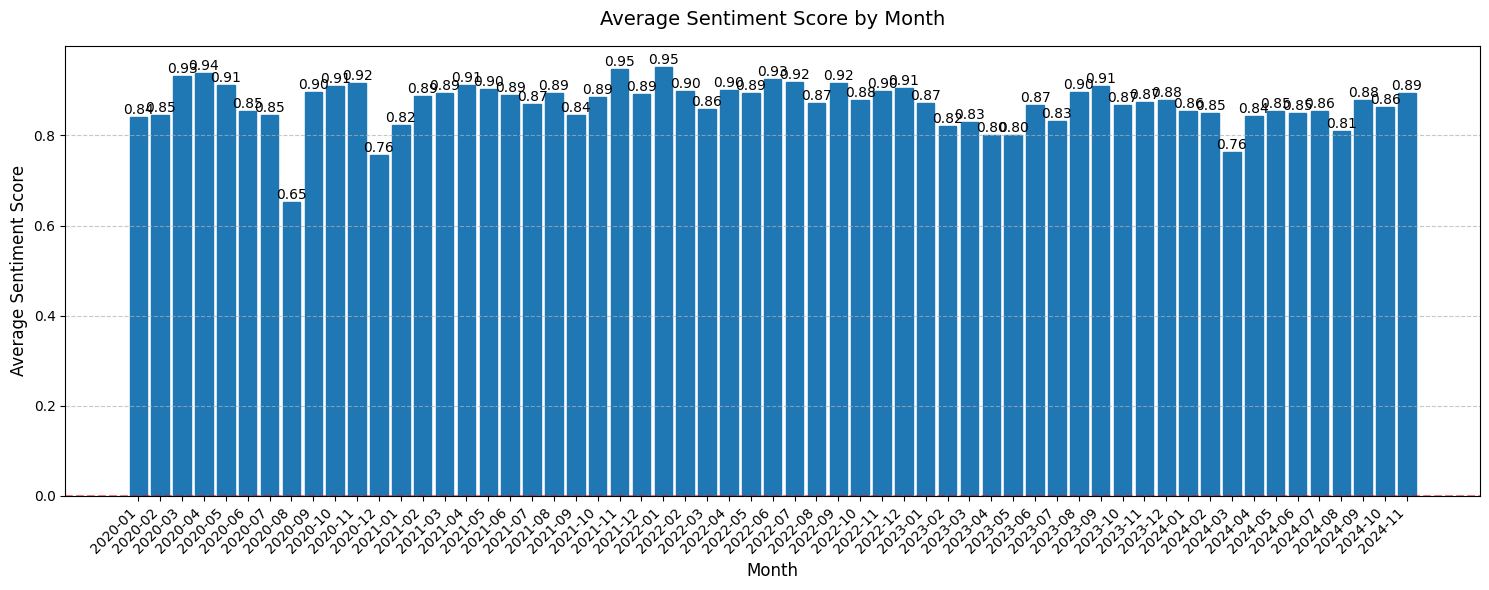


Monthly Sentiment Summary:
   date  sentiment_score
2020-01         0.840995
2020-02         0.845548
2020-03         0.932239
2020-04         0.939180
2020-05         0.911497
2020-06         0.854309
2020-07         0.845703
2020-08         0.651274
2020-09         0.896852
2020-10         0.908489
2020-11         0.917001
2020-12         0.755557
2021-01         0.822825
2021-02         0.887897
2021-03         0.893537
2021-04         0.910762
2021-05         0.903629
2021-06         0.889783
2021-07         0.870375
2021-08         0.892926
2021-09         0.844838
2021-10         0.885026
2021-11         0.948368
2021-12         0.892375
2022-01         0.951111
2022-02         0.897632
2022-03         0.859456
2022-04         0.901335
2022-05         0.893337
2022-06         0.925855
2022-07         0.918838
2022-08         0.870851
2022-09         0.915787
2022-10         0.879233
2022-11         0.899126
2022-12         0.905547
2023-01         0.871592
2023-02         0.8211

In [58]:
# Calculate monthly average sentiment scores
monthly_sentiment = df.groupby(df['date'].dt.strftime('%Y-%m'))[['sentiment_score']].mean().reset_index()

# Sort by date
monthly_sentiment = monthly_sentiment.sort_values('date')

# Create the bar plot
plt.figure(figsize=(15, 6))

# Create bars
bars = plt.bar(monthly_sentiment['date'], 
               monthly_sentiment['sentiment_score'],
            )

# Customize the plot
plt.title('Average Sentiment Score by Month', fontsize=14, pad=15)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Average Sentiment Score', fontsize=12)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Add grid lines
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add reference line at y=0
plt.axhline(y=0, color='red', linestyle='--', alpha=0.5)

# Color bars based on sentiment (positive/negative)
for bar in bars:
    if bar.get_height() >= 0:
        bar.set_color('#1f77b4')  # green for positive
    else:
        bar.set_color('#e74c3c')  # red for negative

# Add value labels on top of each bar
for i, v in enumerate(monthly_sentiment['sentiment_score']):
    plt.text(i, v, f'{v:.2f}', 
             ha='center', va='bottom' if v >= 0 else 'top',
             fontsize=10)

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Show the plot
plt.show()

# Print summary statistics
print("\nMonthly Sentiment Summary:")
print(monthly_sentiment.to_string(index=False))

## Topic Detection

In [29]:
df = pd.read_csv("data_with_sentiments.csv")

In [30]:
df.shape

(187399, 8)

In [31]:
df = df[df['text'].notna()]

In [32]:
df.shape

(187386, 8)

In [33]:
print(df['text'].apply(type).unique())

[<class 'str'>]


In [13]:
import math
from joblib import Parallel, delayed
import spacy

In [42]:
import torch
print(torch.cuda.is_available())  # Should return True if a GPU is available
print(torch.cuda.current_device())  # Should print the GPU device ID

True
0


In [40]:
# Set random state for reproducibility
RANDOM_STATE = 42

# Step 1 - Embedding Model (using GPU)
embedding_model = SentenceTransformer("all-MiniLM-L6-v2", device="cuda")  # Ensure GPU usage

# Step 2 - Reduce Dimensionality (smaller number of dimensions)
umap_model = UMAP(
    n_neighbors=11,
    n_components=10, 
    metric='cosine',
    random_state=42
)

# Step 3 - Clustering Model
hdbscan_model = HDBSCAN(
    min_cluster_size=30,
    metric='euclidean',
    cluster_selection_method='eom',
    prediction_data=True
)

# Step 4 - Tokenization Model
vectorizer_model = CountVectorizer(
    stop_words="english",
    ngram_range=(1,1) 
)

# Step 5 - Create Topic Representation
ctfidf_model = ClassTfidfTransformer()

# Step 6 - Instantiate BERTopic with custom components
topic_model = BERTopic(
    embedding_model=embedding_model,
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    vectorizer_model=vectorizer_model,
    ctfidf_model=ctfidf_model,
)





In [43]:
topics, probs = topic_model.fit_transform(df["text"])

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

In [44]:
print(topic_model.get_topics())

print(
    len(topics) == len(df["text"]),
    topics, # topics assignmetns of first 10 articles,
    sep="\n\n"
)

{-1: [('gray', 0.0012058599327939782), ('ai', 0.001085296644691477), ('group', 0.0010278820064660561), ('said', 0.0009726041782775877), ('new', 0.0009347774088622625), ('content', 0.0009306148410233824), ('data', 0.0009079773409480311), ('media', 0.0009058524104461582), ('use', 0.0008965999164743147), ('prnewswire', 0.0008920631567755435)], 0: [('overviewview', 0.00935097758017826), ('cision', 0.008169766418501256), ('consumer', 0.006920593287934638), ('telecommunications', 0.006453784252429662), ('general', 0.006349668081230885), ('products', 0.006202383091207751), ('transportation', 0.0061881953973069665), ('entertainment', 0.006105178901050747), ('resources', 0.006024950213485226), ('overview', 0.006018458707841774)], 1: [('newswires', 0.017112566381638213), ('presswire', 0.010508336930836153), ('ein', 0.010212596714199622), ('dakota', 0.007464481202611126), ('virginia', 0.0070347011005788395), ('carolina', 0.006852594280036142), ('releases', 0.006536527445816544), ('distribution', 

In [45]:
topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,72691,-1_gray_ai_group_said,"[gray, ai, group, said, new, content, data, me...",[What is medical artificial intelligence AI? ...
1,0,4002,0_overviewview_cision_consumer_telecommunications,"[overviewview, cision, consumer, telecommunica...","[Nick Von, Inbox Profits CEO, Announces Propri..."
2,1,2673,1_newswires_presswire_ein_dakota,"[newswires, presswire, ein, dakota, virginia, ...",[Global Policy Advisors to Host Session on Cor...
3,2,1720,2_menafn_currencies_mena_uae,"[menafn, currencies, mena, uae, arab, saudi, s...",[Enterprise Artificial Intelligence AI Market ...
4,3,1536,3_art_adobe_image_images,"[art, adobe, image, images, dalle, artists, cr...",[Shutterstocks new AI image editor transforms ...
...,...,...,...,...,...
994,993,30,993_vase_rawpixel_flower_plant,"[vase, rawpixel, flower, plant, px, 300, house...",[Window flower plant vase. AI Free Photo raw...
995,994,30,994_fever_football_watchfriday_bureauinvestiga...,"[fever, football, watchfriday, bureauinvestiga...",[Hohem Shines at IFA and IBC Exhibitions with ...
996,995,30,995_ssds_xda_cpus_chromeos,"[ssds, xda, cpus, chromeos, graphics, chromebo...",[This new SBC can run Android 12 and output 6 ...
997,996,30,996_favorites_caption_edweek_remove,"[favorites, caption, edweek, remove, teaching,...",[Education and Tech Heavy Hitters Launch AI Le...


In [46]:
# Save the BERTopic model to disk
topic_model.save("bertopic_model", save_embedding_model=True)


2024-12-13 04:18:30,270 - BERTopic - WARNING: When you use `pickle` to save/load a BERTopic model,please make sure that the environments in which you saveand load the model are **exactly** the same. The version of BERTopic,its dependencies, and python need to remain the same.


In [47]:
# Reduce topics based on similarity
topic_model.reduce_topics(df['text'], nr_topics=40)  # Merge topics into 10 groups


In [92]:
topic_model_original = BERTopic.load("bertopic_model", embedding_model="all-MiniLM-L6-v2")

In [91]:
topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,72691,-1_ai_news_new_data,"[ai, news, new, data, technology, intelligence...",[How conversational AI is enhancing customer e...
1,0,50475,0_ai_news_technology_new,"[ai, news, technology, new, media, business, d...",[A 69 Billion Global Opportunity for Artificia...
2,1,41443,1_market_ai_intelligence_artificial,"[market, ai, intelligence, artificial, data, r...",[Global Artificial Intelligence AI in Automoti...
3,2,5674,2_rawpixel_px_300_generated,"[rawpixel, px, 300, generated, image, rawpixel...",[Architecture building outdoors house. AI Pre...
4,3,3307,3_ai_health_und_drug,"[ai, health, und, drug, market, zu, healthcare...",[Edge AI Software Market Generated 600 Million...
5,4,3054,4_traded_stock_price_shares,"[traded, stock, price, shares, btc, best, trad...",[Link Machine Learning Price Down 1.2 Over Las...
6,5,1965,5_india_news_world_vs,"[india, news, world, vs, live, 2024, dh, ai, 2...",[Business News Worlds LongestRunning AI Show ...
7,6,1156,6_climate_science_learning_eurekalert,"[climate, science, learning, eurekalert, machi...",[Fighting fires from space in record time How ...
8,7,874,7_music_song_ai_spotify,"[music, song, ai, spotify, songs, artists, new...",[How to use AI to write songs and make music v...
9,8,744,8_lg_yes_cookies_slide,"[lg, yes, cookies, slide, tv, product, oled, a...",[77 GX LG OLED TV with ThinQ AI OLED77GXPUA ...


In [90]:
topic_model.get_topic_info()[].to_csv("topics.csv")

In [61]:
df['topic'] = topics

In [62]:
df.head()

,Unnamed: 0,url,date,language,title,text,sentiment_score,sentiment_label,topic
0,0,http://spaceref.com/astronomy/observation-simu...,2021-07-05,en,"Observation, Simulation, And AI Join Forces To...","Observation, Simulation, And AI Join Forces To...",0.9949,Positive,65
1,1,http://www.agoravox.it/Covid-19-un-messaggio-d...,2020-03-13,en,Covid-19: un messaggio dai ricercatori italian...,Covid19 un messaggio dai ricercatori italiani ...,0.9987,Positive,117
2,2,http://www.dataweek.co.za/21690r,2024-04-05,en,Flash for AI - 28 March 2024 - EBV Electrolink...,Flash for AI 28 March 2024 EBV Electrolink ...,0.9995,Positive,949
3,3,http://www.envirolink.org/2021/03/11/hundreds-...,2021-03-11,en,Hundreds of sewage leaks detected thanks to AI...,Hundreds of sewage leaks detected thanks to AI...,0.8970,Positive,-1
4,4,http://www.millenniumpost.in/big-stories/ai-ex...,2020-08-07,en,Two dead as AI Express flight skids off Kozhik...,Two dead as AI Express flight skids off Kozhik...,-0.9812,Negative,94


In [63]:
positive_articles = df[df['sentiment_score'] > 0]
negative_articles = df[df['sentiment_score'] <= 0]

In [65]:
positive_topic_freq = positive_articles[['topic']].value_counts().head(10)
negative_topic_freq = negative_articles[['topic']].value_counts().head(10)

In [66]:
positive_topic_words = {
    topic: topic_model.get_topic(topic) for topic in positive_topic_freq.index
}
negative_topic_words = {
    topic: topic_model.get_topic(topic) for topic in negative_topic_freq.index
}

In [73]:
def plot_topics(topic_freq, topic_words, title):
    labels = []
    for topic in topic_freq.index:# Ensure words is a non-empty list
        topic_label = f"Topic {topic}"
        labels.append(topic_label)

    # Plot
    plt.figure(figsize=(10, 6))
    plt.barh(labels, topic_freq.values, color='skyblue')
    plt.xlabel('Frequency')
    plt.title(title)
    plt.gca().invert_yaxis()
    plt.show()


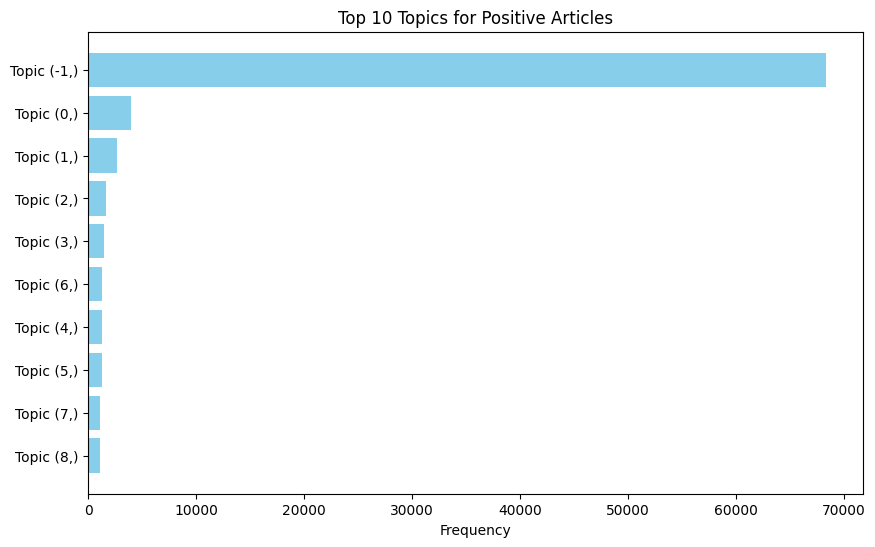

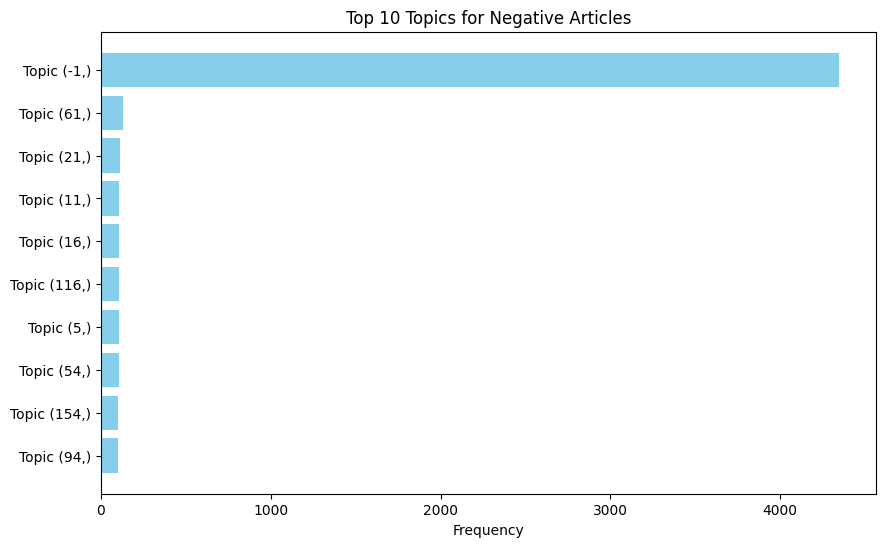

In [74]:
# Plot for positive articles
plot_topics(positive_topic_freq, positive_topic_words, "Top 10 Topics for Positive Articles")

# Plot for negative articles
plot_topics(negative_topic_freq, negative_topic_words, "Top 10 Topics for Negative Articles")

In [87]:
topic_model.get_topic(-1)

[('ai', 0.01655132343680702),
 ('news', 0.009546559141442453),
 ('new', 0.00902078681351727),
 ('data', 0.008417050785715726),
 ('technology', 0.007601026383284949),
 ('intelligence', 0.00735542758473114),
 ('said', 0.0070220838006965864),
 ('artificial', 0.006674399491873812),
 ('2023', 0.006618132816875875),
 ('market', 0.006508941625689561)]

In [76]:
topic_model.get_topic(0)

[('ai', 0.012258926946129584),
 ('news', 0.01218395542298282),
 ('technology', 0.008588561132072651),
 ('new', 0.00857759182906299),
 ('media', 0.008254609868097722),
 ('business', 0.008231727406718379),
 ('data', 0.00778579453642431),
 ('services', 0.007308568525441625),
 ('health', 0.006659489042850575),
 ('public', 0.006388423697455174)]

In [77]:
topic_model.get_topic(1)

[('market', 0.0214410406730141),
 ('ai', 0.016620873733804255),
 ('intelligence', 0.011343711212851658),
 ('artificial', 0.010776633578417285),
 ('data', 0.010727358240036452),
 ('report', 0.009618196851334925),
 ('analysis', 0.009193931399752556),
 ('global', 0.009072687580342883),
 ('new', 0.0090633989642315),
 ('news', 0.008621730707498504)]

In [78]:
topic_model.get_topic(2)

[('rawpixel', 0.23477618103064168),
 ('px', 0.1713913158181769),
 ('300', 0.15875739052515297),
 ('generated', 0.09649877220557362),
 ('image', 0.0794480515817418),
 ('rawpixelrawpixelelementsdesignsdesign', 0.06417895000625042),
 ('comkeywords', 0.06417452991693652),
 ('channel2024', 0.0641729576888836),
 ('topicsboards', 0.0641729576888836),
 ('topicselement', 0.0641729576888836)]

In [79]:
topic_model.get_topic(3)

[('ai', 0.015161758533596005),
 ('health', 0.01337957998267025),
 ('und', 0.01244237187283044),
 ('drug', 0.011165917733669163),
 ('market', 0.010955124967564914),
 ('zu', 0.010952192098913231),
 ('healthcare', 0.010438109134988955),
 ('patients', 0.010247495898870867),
 ('die', 0.010189463010880525),
 ('medical', 0.00968472376511075)]

In [80]:
topic_model.get_topic(4)

[('traded', 0.032039008477453064),
 ('stock', 0.031623462774682684),
 ('price', 0.03058115659592105),
 ('shares', 0.030124653582862794),
 ('btc', 0.027624437962301976),
 ('best', 0.02618670452600831),
 ('trades', 0.025711272887715353),
 ('dollar', 0.025066446097275444),
 ('buy', 0.02462338362972357),
 ('trading', 0.024048954520536608)]

In [81]:
topic_model.get_topic(5)

[('india', 0.02627461854150927),
 ('news', 0.015760846230447247),
 ('world', 0.011950199137296287),
 ('vs', 0.010714691165560515),
 ('live', 0.010397040998018695),
 ('2024', 0.009784986080740497),
 ('dh', 0.00969347285720591),
 ('ai', 0.009662694296736721),
 ('2023', 0.009658719623137834),
 ('delhi', 0.009624578816531053)]

In [82]:
topic_model.get_topic(6)

[('climate', 0.01726872660942298),
 ('science', 0.01620365878207088),
 ('learning', 0.01205868687279294),
 ('eurekalert', 0.011909137140046702),
 ('machine', 0.011804699246332732),
 ('news', 0.01072190674454729),
 ('earth', 0.010649258682999558),
 ('new', 0.010448420908038332),
 ('researchers', 0.010128566447368516),
 ('ai', 0.00991758445757377)]

In [83]:
topic_model.get_topic(7)

[('music', 0.06089515962142664),
 ('song', 0.020229933479867065),
 ('ai', 0.017529158726039433),
 ('spotify', 0.01737977826569134),
 ('songs', 0.015467351801417848),
 ('artists', 0.015315773671318927),
 ('new', 0.014114154553256694),
 ('like', 0.010250399515695844),
 ('news', 0.010071958342970753),
 ('dj', 0.010024453056805088)]

In [84]:
topic_model.get_topic(8)

[('lg', 0.11615966384123659),
 ('yes', 0.0381264247123596),
 ('cookies', 0.03488725634847731),
 ('slide', 0.030689626037826115),
 ('tv', 0.030292670542074157),
 ('product', 0.02855154109297463),
 ('oled', 0.02816628617830517),
 ('air', 0.02651607974267938),
 ('appliances', 0.024989659694716147),
 ('monitors', 0.024122639090279566)]

In [85]:
topic_model.get_topic(9)

[('edt', 0.09173746038885693),
 ('pm', 0.08177809764611277),
 ('est', 0.07086112152754828),
 ('2023', 0.04674878192518747),
 ('2024', 0.027706600157303234),
 ('jan', 0.021929466127283942),
 ('apr', 0.019723897437427716),
 ('feb', 0.01947466219174681),
 ('2020', 0.019006108843681202),
 ('mar', 0.018004407322700224)]

In [86]:
topic_model.get_topic(10)

[('lebanon', 0.02633030255971758),
 ('saudi', 0.018139046813489587),
 ('news', 0.01738594455284107),
 ('world', 0.013486741834641713),
 ('israel', 0.0132898605910414),
 ('south', 0.012129917497145187),
 ('guinea', 0.011979298625603969),
 ('cyprus', 0.011433577591998662),
 ('israeli', 0.011088041306364349),
 ('saint', 0.010818829691845307)]

In [89]:
topic_model.get_topic(21)

[('steam', 0.12053930696580563),
 ('steamdb', 0.08938737194395135),
 ('games', 0.06939552012042316),
 ('azure', 0.058783830111559895),
 ('depot', 0.0580451110380102),
 ('redirected', 0.056804764627759824),
 ('sentinel', 0.05468043889857057),
 ('game', 0.049229470921453765),
 ('calculator', 0.04916590554306123),
 ('upcoming', 0.04170276419735795)]

In [94]:
topic_model_original.get_topic(61)

[('lawsuit', 0.014093434295790927),
 ('copyright', 0.01132107205666219),
 ('authors', 0.010860858609898832),
 ('openai', 0.00980922206734924),
 ('infringement', 0.008331598794361338),
 ('copyrighted', 0.007969913074280563),
 ('times', 0.005415849593662026),
 ('filed', 0.005176029079520383),
 ('silverman', 0.005118793315753148),
 ('york', 0.005046399396473686)]

In [95]:
topic_model_original.get_topic(21)

[('lunit', 0.015450309773358071),
 ('cancer', 0.01378290827822704),
 ('breast', 0.011353615661420832),
 ('clinical', 0.008719228533366988),
 ('patient', 0.00859784855655982),
 ('patients', 0.007712630812954177),
 ('osf', 0.006855121443276827),
 ('care', 0.006641263901263834),
 ('radiologists', 0.005708079280379931),
 ('medical', 0.005629144167381078)]

In [96]:
topic_model_original.get_topic(11)

[('india', 0.007403425910771882),
 ('viral', 0.006284273871814288),
 ('vs', 0.006018744275848303),
 ('latestly', 0.005589220383964345),
 ('delhi', 0.004915226503771153),
 ('festivals', 0.0047556477304869236),
 ('mumbai', 0.0045986800386909575),
 ('searches', 0.004128469386018983),
 ('pics', 0.004117490668019538),
 ('indian', 0.004095814543965377)]

In [97]:
topic_model_original.get_topic(16)

[('star', 0.006577506610380156),
 ('reveals', 0.005884366885794033),
 ('husband', 0.00515922336790094),
 ('daughter', 0.004907585392520349),
 ('dress', 0.004881512688430609),
 ('wife', 0.004699102330204076),
 ('fans', 0.004449518650917923),
 ('taylor', 0.0044022630751541485),
 ('looks', 0.003949873712692712),
 ('shes', 0.0038682677073860554)]

In [98]:
topic_model_original.get_topic(116)

[('america', 0.09387364896756618),
 ('chief', 0.0910016698651855),
 ('north', 0.08420624997195844),
 ('business', 0.021960247337013565),
 ('smarter', 0.01843893009759975),
 ('technology', 0.01830403093725149),
 ('blackberry', 0.017893685262441412),
 ('canadian', 0.010935850247709116),
 ('canada', 0.007147802214126498),
 ('5mn', 0.007065112898835433)]

In [99]:
topic_model_original.get_topic(5)

[('federal', 0.004168235070480186),
 ('cookie', 0.003930925521489165),
 ('agencies', 0.003741431378452532),
 ('defense', 0.0036924174118308528),
 ('government', 0.0036690930770451606),
 ('force', 0.0036276350970469553),
 ('military', 0.003387419207029731),
 ('fedscoop', 0.0033613909060722425),
 ('house', 0.003338138359937894),
 ('pentagon', 0.003146112879956203)]

In [100]:
topic_model_original.get_topic(54)

[('clearview', 0.03510212038266829),
 ('facial', 0.01720362095280053),
 ('recognition', 0.011485949951524518),
 ('police', 0.008868628505437518),
 ('enforcement', 0.007067857013856755),
 ('clearviews', 0.006495186473172795),
 ('biometric', 0.004801125470455216),
 ('law', 0.0046775284960746165),
 ('policing', 0.004151783339891742),
 ('privacy', 0.003903023293647423)]

In [101]:
topic_model_original.get_topic(154)

[('jones', 0.044359494499325594),
 ('rebekah', 0.022977088851454188),
 ('florida', 0.021453375731792627),
 ('warrant', 0.01589660333409609),
 ('fdle', 0.01500253955326963),
 ('raid', 0.013694522944414773),
 ('fired', 0.013306886976000337),
 ('desantis', 0.013204943605316677),
 ('department', 0.010524351703080413),
 ('scientist', 0.01015564145230955)]

In [102]:
topic_model_original.get_topic(94)

[('flight', 0.019108110159119243),
 ('flights', 0.01600199168868631),
 ('india', 0.015973967781911364),
 ('air', 0.015194624531668135),
 ('express', 0.013949966434533119),
 ('passengers', 0.013413506298009263),
 ('dgca', 0.012986637058550146),
 ('crew', 0.012680699015103842),
 ('plane', 0.010833954467801232),
 ('airline', 0.010713859167005188)]

In [59]:
topics

[65,
 117,
 949,
 -1,
 94,
 144,
 29,
 186,
 20,
 -1,
 571,
 3,
 -1,
 -1,
 -1,
 -1,
 79,
 -1,
 44,
 433,
 -1,
 -1,
 218,
 241,
 241,
 132,
 -1,
 -1,
 347,
 -1,
 -1,
 17,
 -1,
 887,
 624,
 -1,
 521,
 -1,
 20,
 5,
 -1,
 67,
 20,
 886,
 216,
 382,
 382,
 -1,
 65,
 642,
 -1,
 925,
 65,
 65,
 65,
 -1,
 -1,
 54,
 65,
 -1,
 779,
 -1,
 -1,
 6,
 -1,
 -1,
 79,
 -1,
 -1,
 4,
 475,
 -1,
 -1,
 392,
 -1,
 -1,
 31,
 5,
 434,
 -1,
 174,
 350,
 286,
 -1,
 696,
 42,
 42,
 42,
 444,
 330,
 67,
 -1,
 419,
 329,
 11,
 -1,
 201,
 492,
 49,
 30,
 8,
 892,
 54,
 -1,
 -1,
 20,
 573,
 70,
 36,
 390,
 -1,
 -1,
 25,
 574,
 73,
 233,
 6,
 -1,
 29,
 -1,
 117,
 20,
 19,
 221,
 221,
 22,
 597,
 230,
 230,
 230,
 2,
 -1,
 -1,
 -1,
 -1,
 2,
 2,
 2,
 151,
 136,
 -1,
 59,
 -1,
 137,
 22,
 322,
 -1,
 22,
 91,
 -1,
 101,
 833,
 225,
 18,
 -1,
 658,
 524,
 54,
 -1,
 170,
 -1,
 288,
 -1,
 22,
 18,
 18,
 29,
 18,
 833,
 7,
 -1,
 61,
 61,
 -1,
 612,
 155,
 -1,
 559,
 -1,
 623,
 623,
 6,
 -1,
 41,
 440,
 7,
 211,
 -1,
 54,
 836

## 